In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [167]:
class SHE():
    def __init__(self, N = 100, g  =1 , u = 0.25 , T = 0.5, CFL = 0.5):
        self.N = N
        self.g = g
        self.dx = 2/(N)
        self.k = None
        self.u = u
        self.bc = None
        h = np.zeros(N+1)
        m = np.zeros(N+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N+1)
        self.CFL = 0.5
        self.T = T
        self.t = 0
        self.h0 = None
        self.use_source = True

    def update_k(self):
        u = self.q[1] / self.q[0]
        self.k = self.CFL * self.dx / (np.max(np.abs(u) + np.sqrt(self.g*self.q[0])))
    
    def update_N(self, N_new):
        self.N = N_new
        self.dx = 2/N_new
        h = np.zeros(N_new+1)
        m = np.zeros(N_new+1)
        self.q = np.array([h,m])
        self.x = np.linspace(0, 2, N_new+1)
    
    def IV(self , h:callable , m:callable):
        self.h0 = h
        self.q[0] = h(self.x)
        self.q[1] = m(self.x)

    def f(self , u):
        #print(f"u_1 is {u[0],u[1]}")
        return np.array([u[1], ((u[1]**2)/u[0]) + 0.5*self.g*(u[0]**2)])
    
    def Jf(self, u):
        Jf = np.ndarray((2,2))
        Jf[0,0] = 0
        Jf[0,1] = 1
        Jf[1,0] = (-1)*(u[1]**2)/(u[0]**2) + self.g*u[0]
        Jf[1,1] = 2*(u[1]/u[0])
        return Jf
    
    def F(self , u,v):
        #print(u.shape)
        #print(self.f(u) + self.f(v))
        #print(np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.k / self.dx)*(v - u)))
        return np.array(0.5 * (self.f(u) + self.f(v)) - 0.5*(self.dx / self.k)*(v - u))
    
    def S(self, x_val):
        s1 = np.pi/2 * (self.u-1) * np.cos(np.pi*(x_val-self.t))
        s2 = np.pi/2 * np.cos(np.pi*(x_val-self.t)) * (-self.u+(self.u**2)+self.g*self.h0(x_val-self.t))
        #print(s1,s2)
        return np.array([s1, s2])
    
    def FLW(self,u,v):
        '''
            Question for Jun: in LW method we have to evaluate f'((u+v)/2) but here f:R^2->R^2 so f' = Jf. 
            Jf((u+v)/2) (f(v)-f(u)) \in R^2 so should be fine, what do you think?
        '''
        return np.array(0.5*(self.f(u)+self.f(v)) - 0.5*(self.k/self.dx)*(self.Jf(0.5*(u+v))@(self.f(v)-self.f(u))))

    def set_BC(self , bc):
        self.bc = bc
        
    def set_Source(self , us):
        # boolean
        self.use_source = us

    def Solve(self):
        self.t=0

        if self.bc=="P":
            while self.t < self.T:
                #print(self.t)

                #print(f"Hi, from time {self.t} with {self.q[0,0]}")
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t
                

                q_old = self.q.copy()

                for j in range(self.N+1):

                    flux_term = self.F(q_old[:,j] , q_old[:,(j+1) % self.N]) - self.F(q_old[:, (j-1) % self.N] , q_old[:,j])
                    #print(flux_term)
                    #print(flux_term.shape)
                    #print(self.q[:,j])
                    #print(q_old[:,j])
                    #y = self.S(self.dx * j)
                    #print(y)
                    #print(self.S(self.dx * j))
                    
                    if(self.use_source):
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    else:
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term
                    #break
                    
                
                self.t += self.k
                #break
                
        elif self.bc=="O":
            while self.t < self.T:
                self.update_k()

                if self.t + self.k > self.T:
                    self.k = self.T - self.t

                self.t += self.k
                q_old = self.q.copy()
                for j in range(1 , self.N):
                    flux_term = self.F(q_old[:,j] , q_old[:,(j+1)]) - self.F(q_old[:, (j-1)] , q_old[:,j])
                    
                    if(self.use_source):
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term + self.k * self.S(self.dx * j)
                    else:
                        self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term
                        

                self.q[:,0] = self.q[:,1]
                self.q[:,self.N] = self.q[:,self.N-1]
            
    '''
        Question for Jun:
        There is something wrong thsat I don't see, the same bc on the other method seems to work fine.
        Here we have the same problem of a negative sqrt, can you take a look?
    '''
    def SolveLW(self):
        self.t = 0
        
        while self.t < self.T:
            self.update_k()

            if self.t + self.k > self.T:
                self.k = self.T - self.t
            self.t += self.k

            q_old = self.q.copy()
            
            for j in range(1, self.N):
                flux_term = self.FLW(q_old[:,j] , q_old[:,(j+1) % self.N]) - self.FLW(q_old[:, (j-1) % self.N] , q_old[:,j])
                self.q[:,j] = q_old[:,j] - (self.k/self.dx)*flux_term
                
            self.q[:,0] = self.q[:,1]
            self.q[:,self.N] = self.q[:,self.N-1]

In [129]:
### Implementing all the initial values:

#A
def h0_A(x):
    return 1 + 0.5*np.sin(np.pi * x)

def m0_A(x , u = 0.25):
    return u * h0_A(x)
    
#B
def h0_B(x):
    return 1 - 0.1*np.sin(np.pi * x)

def m0_B(x , u = 0.25):
    return 0


#C
def h0_C(x):
    return 1 - 0.2*np.sin(2 * np.pi * x)

def m0_C(x , u = 0.25):
    return 0.5

#D
def h0_D(x):
    return 1

def m0_D(x , u = 0.25):
    return np.piecewise(x, [x < 1, x>1], [lambda x: -1.5, lambda x: 0])

In [130]:
def h_exact(x , t) : 
    #return 1 - 0.1*np.sin(np.pi*(x - t))
    return 1+ 0.5*np.sin(np.pi*(x - t))
def m_exact(x,t):
    #return np.zeros_like(x)
    return 0.25 * h_exact(x , t)

# Problem 1.b

In [53]:
# Define Problem
time = 2
Problem = SHE(T =time)

# Set Bc
Problem.set_BC("P")

step = 50
num_steps = 20
error = np.array([])

original_N = Problem.N
for n in np.linspace(original_N, original_N+num_steps*step, num_steps+1, dtype=int):
    print(f"Doing test with N={n}")
    Problem.update_N(n)
    
    Problem.IV(h0_A , m0_A)

    Problem.Solve()
    '''
        Question for Jun: what norm do you want to use for the error, I put 2-norm but we have to think about it
        I compute in this way (||h - h_exact||_2^2 + ||m - m_exact||_2^2)^(1/2) that is the Frobenius norm for the
        matrix q-q_exact, what norm would you use?
    '''
    h_ex = h_exact(Problem.x , 0.5)
    m_ex = m_exact(Problem.x , 0.5)
    error = np.append(error, np.linalg.norm(Problem.q - np.array([h_ex, m_ex]), 'fro'))

Doing test with N=100
Doing test with N=150
Doing test with N=200
Doing test with N=250
Doing test with N=300
Doing test with N=350
Doing test with N=400
Doing test with N=450
Doing test with N=500
Doing test with N=550
Doing test with N=600
Doing test with N=650
Doing test with N=700
Doing test with N=750
Doing test with N=800
Doing test with N=850
Doing test with N=900
Doing test with N=950
Doing test with N=1000
Doing test with N=1050
Doing test with N=1100


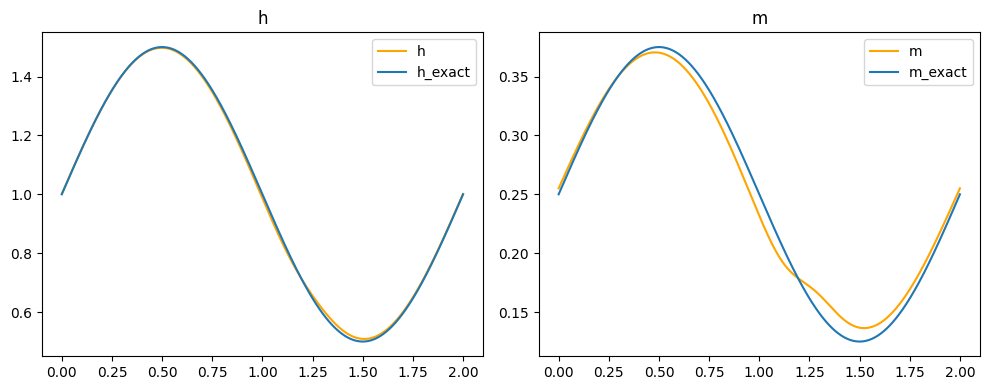

In [54]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

x = Problem.x
h_sol = Problem.q[0]
m_sol = Problem.q[1]

# Plot data on the first subplot
axs[0].plot(x, h_sol, label='h' , color = "orange")
axs[0].plot(x, h_exact(x , time), label='h_exact')
axs[0].set_title('h')
axs[0].legend()

# Plot data on the second subplot
axs[1].plot(x, m_sol, label='m', color='orange')
axs[1].plot(x, m_exact(x , time), label='m_exact')
axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

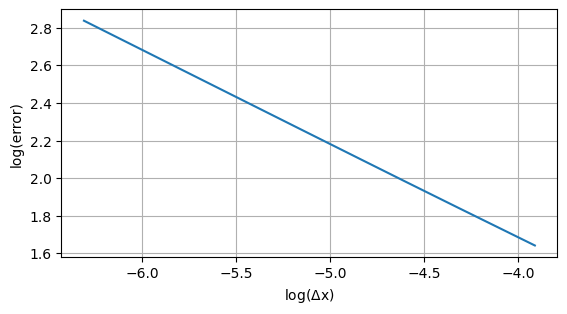

In [55]:
dxs = [2/x for x in np.linspace(original_N, original_N+num_steps*step, num_steps+1)]
plt.plot(np.log(dxs), np.log(error))
plt.xlabel("log($\Delta$x)")
plt.ylabel("log(error)")
plt.grid()
plt.gca().set_aspect('equal')
plt.show()

In [56]:
logError = np.log(error)
logDx = np.log(dxs)

# polynomial decay of error
np.mean((logError[1:]-logError[0:-1]) / (logDx[1:]-logDx[0:-1]))

-0.500140872404255

# Problem 2

In [105]:
# Define Problem
time = 2
Problem = SHE(T =time)

Problem.set_BC("P")

Problem.set_Source(False)

step = 50
num_steps = 20
errorB = np.array([])
errorC = np.array([])

original_N = Problem.N
for n in np.linspace(original_N, original_N+num_steps*step, num_steps+1, dtype=int)[::-1]:
    print(f"Doing test with N={n}")
    Problem.update_N(n)
    
    Problem.IV(h0_B , m0_B)

    Problem.Solve()
    
    if(n==original_N+num_steps*step):
        x_orig = Problem.x
        hB_ex = Problem.q[0].copy()
        mB_ex = Problem.q[1].copy()
    else:    
        h_interp = np.interp(x_orig, Problem.x, Problem.q[0])
        m_interp = np.interp(x_orig, Problem.x, Problem.q[1])
        errorB = np.append(errorB, np.linalg.norm(np.array([h_interp, m_interp]) - np.array([hB_ex, mB_ex]), 'fro'))
    
    Problem.IV(h0_C , m0_C)

    Problem.Solve()
    
    if(n==original_N+num_steps*step):
        x_orig = Problem.x
        hC_ex = Problem.q[0].copy()
        mC_ex = Problem.q[1].copy()
    else:
        h_interp = np.interp(x_orig, Problem.x, Problem.q[0])
        m_interp = np.interp(x_orig, Problem.x, Problem.q[1])
        errorC = np.append(errorC, np.linalg.norm(np.array([h_interp, m_interp]) - np.array([hC_ex, mC_ex]), 'fro'))
    
errorB = errorB[::-1]
errorC = errorC[::-1]

Doing test with N=1100
Doing test with N=1050
Doing test with N=1000
Doing test with N=950
Doing test with N=900
Doing test with N=850
Doing test with N=800
Doing test with N=750
Doing test with N=700
Doing test with N=650
Doing test with N=600
Doing test with N=550
Doing test with N=500
Doing test with N=450
Doing test with N=400
Doing test with N=350
Doing test with N=300
Doing test with N=250
Doing test with N=200
Doing test with N=150
Doing test with N=100


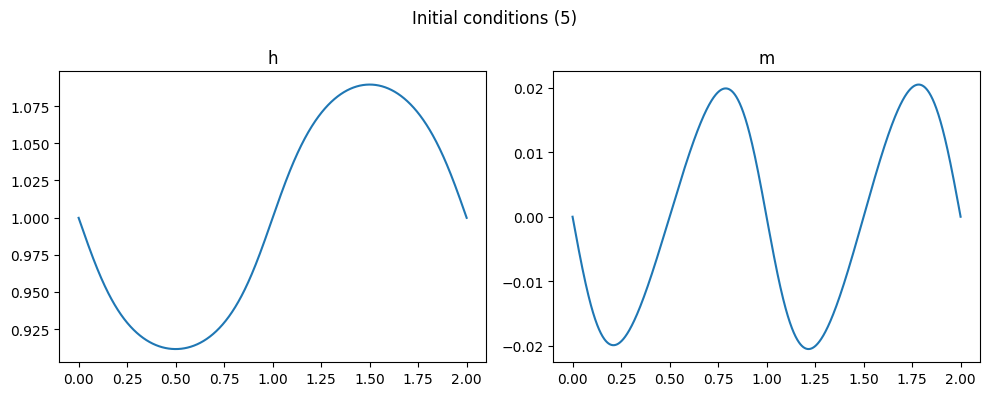

In [106]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Initial conditions (5)")

Problem.update_N(original_N+num_steps*step)
x = Problem.x

# Plot data on the first subplot
axs[0].plot(x, hB_ex, label='h_exact')
axs[0].set_title('h')

# Plot data on the second subplot
axs[1].plot(x, mB_ex, label='m_exact')
axs[1].set_title('m')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

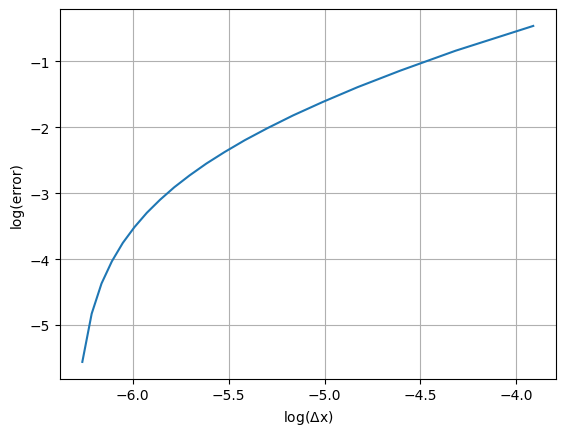

In [107]:
dxs = [2/x for x in np.linspace(original_N, original_N+(num_steps-1)*step, num_steps)]
plt.plot(np.log(dxs), np.log(errorB))
plt.xlabel("log($\Delta$x)")
plt.ylabel("log(error)")
plt.grid()
plt.show()

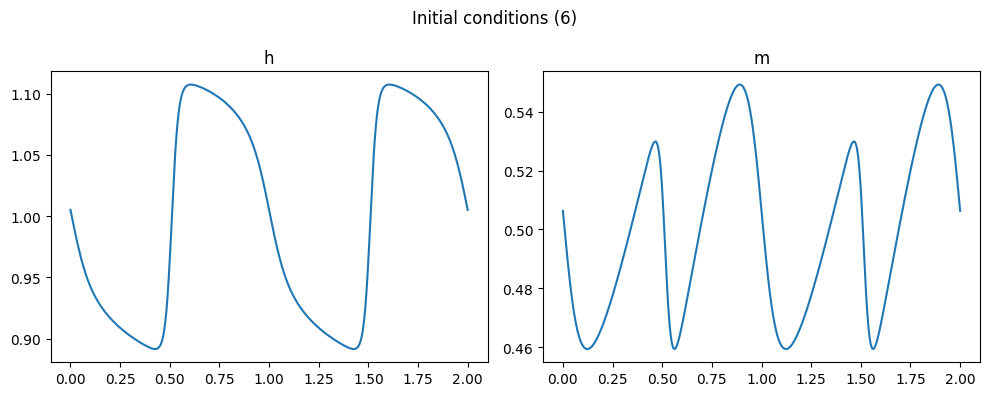

In [108]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

fig.suptitle("Initial conditions (6)")

Problem.update_N(original_N+num_steps*step)
x = Problem.x

# Plot data on the first subplot
axs[0].plot(x, hC_ex, label='h_exact')
axs[0].set_title('h')

# Plot data on the second subplot
axs[1].plot(x, mC_ex, label='m_exact')
axs[1].set_title('m')

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

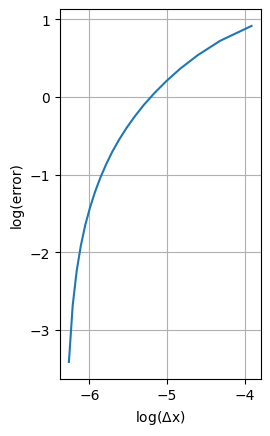

In [109]:
dxs = [2/x for x in np.linspace(original_N, original_N+(num_steps-1)*step, num_steps)]
plt.plot(np.log(dxs), np.log(errorC))
plt.xlabel("log($\Delta$x)")
plt.ylabel("log(error)")
plt.grid()
plt.gca().set_aspect('equal')
plt.show()

# Problem 3.a

In [164]:
### Define Problem
time = 0.5
Problem = SHE(T =time, N=1100)

Problem.set_BC("O")

Problem.set_Source(False)

Problem.IV(h0_D , m0_D)

Problem.Solve()

x_ex = Problem.x.copy()
h_ex = Problem.q[0].copy()
m_ex = Problem.q[1].copy()

# Problem 3.b

Doing test with N=100
Doing test with N=350
Doing test with N=600
Doing test with N=850
Doing test with N=1100


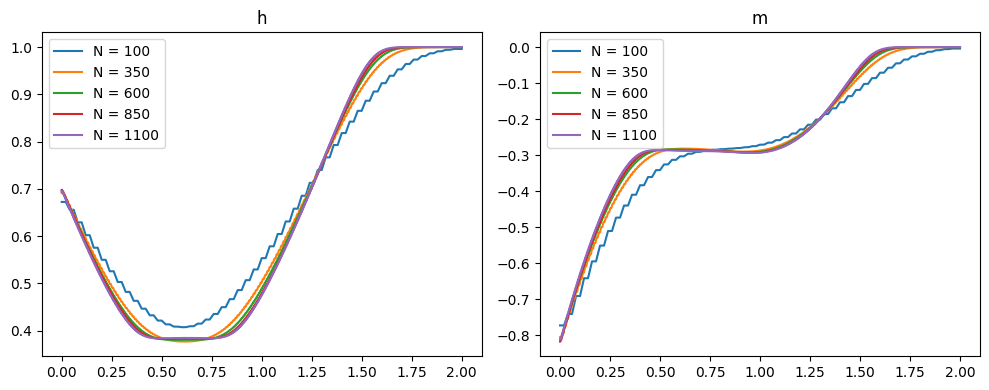

In [165]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

step = 250
num_steps = 4
Problem.update_N(100)
error = np.array([])

original_N = Problem.N
for n in np.linspace(original_N, original_N+num_steps*step, num_steps+1, dtype=int):
    print(f"Doing test with N={n}")
    Problem.update_N(n)
    
    Problem.IV(h0_D , m0_D)

    Problem.Solve()
    
    axs[0].plot(x, np.interp(x_ex, Problem.x, Problem.q[0]), label=f'N = {n}')
    axs[1].plot(x, np.interp(x_ex, Problem.x, Problem.q[1]), label=f'N = {n}')
    

axs[0].set_title('h')
axs[0].legend()

axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()

# Problem 3.c

Doing test with N=100
Doing test with N=350
Doing test with N=600
Doing test with N=850
Doing test with N=1100


/var/folders/_c/53p2ylxx1kvdwvv_9gnhx2c40000gn/T/ipykernel_13720/810475898.py:21: RuntimeWarning: invalid value encountered in sqrt
  self.k = self.CFL * self.dx / (np.max(np.abs(u) + np.sqrt(self.g*self.q[0])))


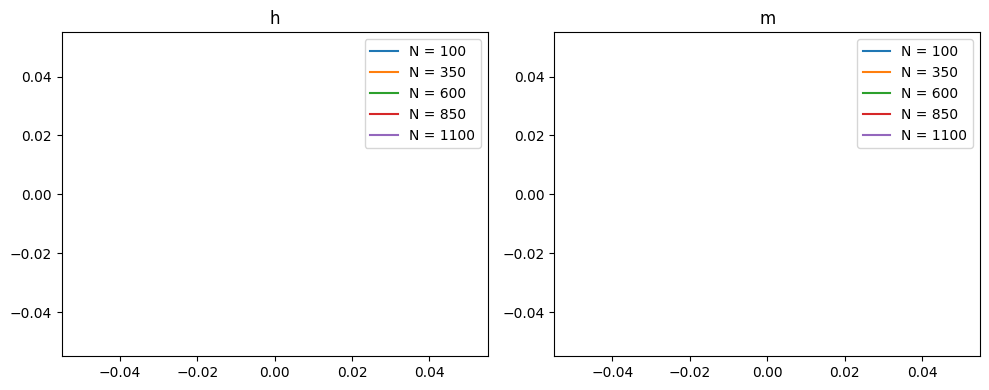

In [166]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

step = 250
num_steps = 4
Problem.update_N(100)
error = np.array([])

original_N = Problem.N
for n in np.linspace(original_N, original_N+num_steps*step, num_steps+1, dtype=int):
    print(f"Doing test with N={n}")
    Problem.update_N(n)
    
    Problem.IV(h0_D , m0_D)

    Problem.SolveLW()
    
    axs[0].plot(x, np.interp(x_ex, Problem.x, Problem.q[0]), label=f'N = {n}')
    axs[1].plot(x, np.interp(x_ex, Problem.x, Problem.q[1]), label=f'N = {n}')
    

axs[0].set_title('h')
axs[0].legend()

axs[1].set_title('m')
axs[1].legend()

# Adjust layout to prevent clipping of titles
plt.tight_layout()

# Show the plot
plt.show()